In [1]:
import numpy as np
import tensorflow as tf

# RHIRL
# import sys
# sys.path.append("../../irl/rhirl/")
# from rhirl import *
# from rhirl_plotting import *

# Simple RL
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# MLIRL

In [2]:
def MLIRL(state_trajectories, action_trajectories,
          states, state_features, 
          actions, trans_dict, optimizer_fn,
          n_iter=1, n_vi_iter=1,
          gamma=0.99, boltzmann_beta=1., 
          dtype=torch.float, print_interval=1):
    
    nS = len(states)
    nA = len(actions)
    state_features = torch.from_numpy(state_features).type(dtype)
    feature_dim = state_features.shape[1]
    state_to_idx = {s:idx for idx,s in enumerate(states)}
    action_to_idx = {a:idx for idx,a in enumerate(actions)}
    softmax = torch.nn.Softmax(dim=0)
    # Reward parameters
    w = Variable(torch.Tensor(feature_dim, 1).normal_(0, 0.1).type(dtype), requires_grad=True) # weight init normal random
    # w = Variable(torch.Tensor(feature_dim, 1).type(dtype), requires_grad=True) # weight init zero
    # torch.ones(feature_dim, 1, dtype=dtype, requires_grad=True)
    optimizer = optimizer_fn([w])
    
    for _iter in range(n_iter):
        # Stochastic Policy
        Pi = torch.ones(nS, nA, dtype=dtype) / nA
        # Reward^~
        R = torch.mm(state_features, w)
        # Value
        V = R[:,0].clone()
        # V = gtorch.zeros(nS, dtype=dtype)
        # Q value
        Q = R.repeat(1,nA).clone()
        # Q = torch.zeros(nS, nA, dtype=dtype)

        for _v_iter in range(n_vi_iter):
            for s_idx, s in enumerate(states):

                phi_s = state_features[s_idx] #torch.from_numpy(phi(s)).type(dtype)
                for a_idx, a in enumerate(actions):

                    Q[s_idx, a_idx] = R[s_idx]
                    for s_prime in trans_dict[s][a]:
                        Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[state_to_idx[s_prime]].clone()
                    Pi[s_idx, :] = softmax(boltzmann_beta * Q[s_idx,:].clone())
                    V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
                    
        optimizer.zero_grad()
        loss = 0
        for traj_idx, state_trajectory in enumerate(state_trajectories):
            for point_idx, state in enumerate(state_trajectory[:-1]):
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action_trajectories[traj_idx][point_idx]]
                loss -= torch.log(Pi[s_idx,a_idx])
        loss.backward()
        if _iter % print_interval == 0 or _iter == n_iter-1:
            print("Iter: {:04d}, loss: {:012.6f}, w: [{}], dw: [{}]".format(
                _iter, loss, ' '.join('%+08.6f'%v for v in w[:,0]), ' '.join('%+08.7f'%v for v in w.grad[:,0])))
        optimizer.step()
    return w, R, Pi, V, Q, loss


# Experiments

In [3]:
def get_action(state, n_state):
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0:
        return "right"
    elif dx > 0 and dy > 0:
        return "up_right"
    elif dx == 0 and dy > 0:
        return "up"
    elif dx < 0 and dy > 0:
        return "up_left"
    elif dx < 0 and dy == 0:
        return "left"
    elif dx < 0 and dy < 0:
        return "down_left"
    elif dx == 0 and dy < 0:
        return "down"
    else: # dx > 0 and dy < 0:
        return "down_right"

def get_actions_from_state_traj(state_traj):
    return [get_action(state_traj[i], state_traj[i+1]) for i in range(len(state_traj)-1)]

def MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=True, figsize=(10,10), print_interval=1):
    
    # Navigation MDP with no goals
    nvmdp = NavigationMDP(width=irl_problem["width"], height=irl_problem["height"],
                          living_cell_types=irl_problem["cell_types"],
                          living_cell_rewards=[0]*len(irl_problem["cell_types"]),
                          living_cell_distribution="manual",
                          living_cell_locs= irl_problem["cell_locs"])
    # Visualize Grid
    if disp_grid:
        nvmdp.visualize_grid(nvmdp.state_space, trajectories=irl_problem["traj_states"], end_marker="*k", goal_marker_sz=10, title=irl_problem["title"])
    
    # MLIRL Inputs
    phi = lambda s: nvmdp.feature_at_state(s, "indicator", incl_cell_distances=False, incl_goal_indicator=False, incl_goal_distances=False, normalize_distance=False)
    phi_loc = lambda x,y: nvmdp.feature_at_loc(x, y, "indicator", incl_cell_distances=False, incl_goal_indicator=False, incl_goal_distances=False, normalize_distance=False)
    states = nvmdp.get_states()
    actions = nvmdp.get_actions()
    state_features = np.asarray([phi(s) for s in states])
    cell_features = np.asarray([[phi_loc(*nvmdp._rowcol_to_xy(row,col)) for col in range(nvmdp.width)] for row in range(nvmdp.height)])
    T = nvmdp.get_trans_dict()
    # MLIRL
    print("Training...")
    w, _, Pi, V, Q, loss = MLIRL(irl_problem["traj_states"], irl_problem["traj_actions"], states, state_features, actions, T, **mlirl_params, print_interval=print_interval)
    print("Done.")
    # Recovered Reward
    R = cell_features.dot(w.data)[:,:,0]
    # Display results
    if disp_results:
        display_irl_results(nvmdp, irl_problem["traj_states"], R, title, figsize)
    return dict(w=w, R=R, Pi=Pi, V=V, Q=Q, nvmdp=nvmdp)

def display_irl_results(nvmdp, tau_s, recovered_R, title="", cmap=None, figsize=(16,10)):
    plt.figure(figsize=figsize)
    nvmdp.visualize_grid(nvmdp.state_space, trajectories=tau_s, new_fig=False, subplot_str="121", 
                         show_colorbar=False, end_marker="*k", title=title)
    nvmdp.visualize_grid(recovered_R, new_fig=False, subplot_str="122", cmap=cmap,
                         text_values=recovered_R, text_size=15, title="MLIRL Recovered R")

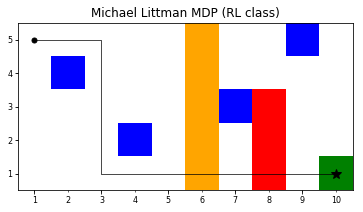

Training...
Iter: 0000, loss: 00017.892710, w: [+0.017033 -0.147737 -0.055691 +0.003438 -0.005797], dw: [+4.3344436 +1.3855897 -0.2733406 -2.2883968 -3.2198951]
Iter: 0001, loss: 00013.790318, w: [-0.418115 -0.271522 -0.022788 +0.231934 +0.316772], dw: [+2.3817995 +1.5858121 +1.9090977 +2.9841754 -8.8349857]
Iter: 0002, loss: 00008.229415, w: [-1.006116 -0.514358 -0.181806 +0.115969 +1.458906], dw: [-1.2753453 +1.2332418 +0.8480334 +1.1116568 -1.9282167]
Iter: 0003, loss: 00006.712808, w: [-1.307171 -0.804798 -0.391545 -0.111161 +2.533757], dw: [-2.3129358 +1.1753507 +0.8558927 +1.0098770 -0.7277449]
Iter: 0004, loss: 00005.329447, w: [-1.216110 -1.103250 -0.626745 -0.405451 +3.320522], dw: [-1.8846608 +0.9859919 +0.7910289 +0.5326849 -0.4295788]
Iter: 0005, loss: 00004.200255, w: [-0.824078 -1.360131 -0.854853 -0.683034 +3.739516], dw: [-0.8742744 +0.7344662 +0.3685994 +0.1236970 -0.3619421]
Iter: 0006, loss: 00003.803905, w: [-0.301414 -1.528757 -1.011525 -0.876926 +3.778853], dw: [-

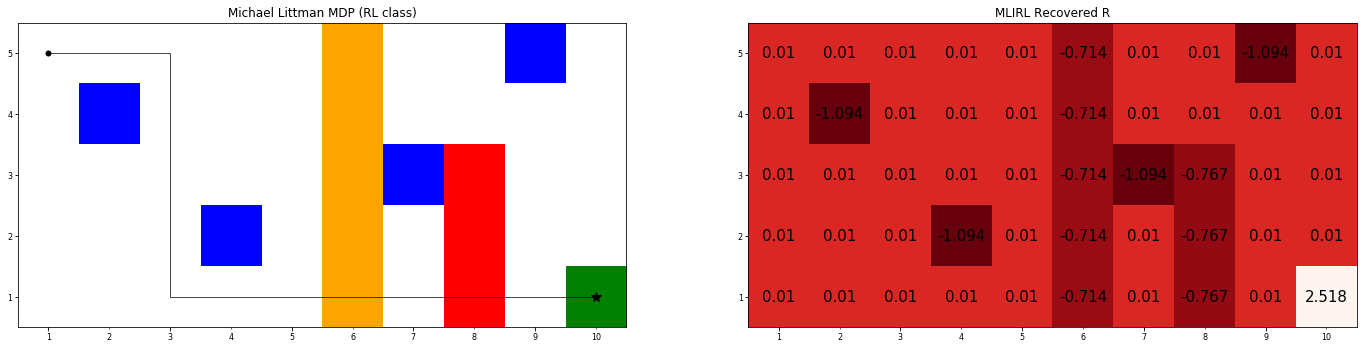

In [4]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 5,
    cell_types = ['white', 'blue', "orange", "red", "green"],
    cell_locs = [np.inf, [(2,4), (4,2), (7,3), (9,5)], [(6,i) for i in range(1,6)], [(8,i) for i in range(1,4)], [(10,1)]],
    tau_s = [[(1,5),(2,5)] + [(3,i) for i in range(5,0,-1)] + [(i,1) for i in range(4,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Michael Littman MDP (RL class)",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(3), irl_problem["title"], cmap=plt.cm.Reds_r, figsize=(24,14))

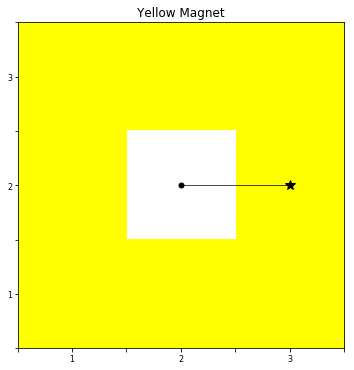

Training...
Iter: 0000, loss: 00001.386147, w: [+0.076594 -0.092039], dw: [+0.0005674 +0.0015610]
Iter: 0001, loss: 00001.386148, w: [+0.075822 -0.091135], dw: [+0.0005651 +0.0015686]
Iter: 0002, loss: 00001.386150, w: [+0.074364 -0.089425], dw: [+0.0005602 +0.0015816]
Iter: 0003, loss: 00001.386153, w: [+0.072302 -0.087007], dw: [+0.0005538 +0.0016025]
Iter: 0004, loss: 00001.386156, w: [+0.069718 -0.083978], dw: [+0.0005462 +0.0016313]
Iter: 0005, loss: 00001.386160, w: [+0.066690 -0.080427], dw: [+0.0005358 +0.0016584]
Iter: 0006, loss: 00001.386165, w: [+0.063292 -0.076445], dw: [+0.0005249 +0.0016956]
Iter: 0007, loss: 00001.386171, w: [+0.059596 -0.072112], dw: [+0.0005130 +0.0017357]
Iter: 0008, loss: 00001.386177, w: [+0.055668 -0.067510], dw: [+0.0004994 +0.0017716]
Iter: 0009, loss: 00001.386184, w: [+0.051572 -0.062710], dw: [+0.0004859 +0.0018143]
Iter: 0010, loss: 00001.386191, w: [+0.047364 -0.057781], dw: [+0.0004711 +0.0018567]
Iter: 0011, loss: 00001.386198, w: [+0.043

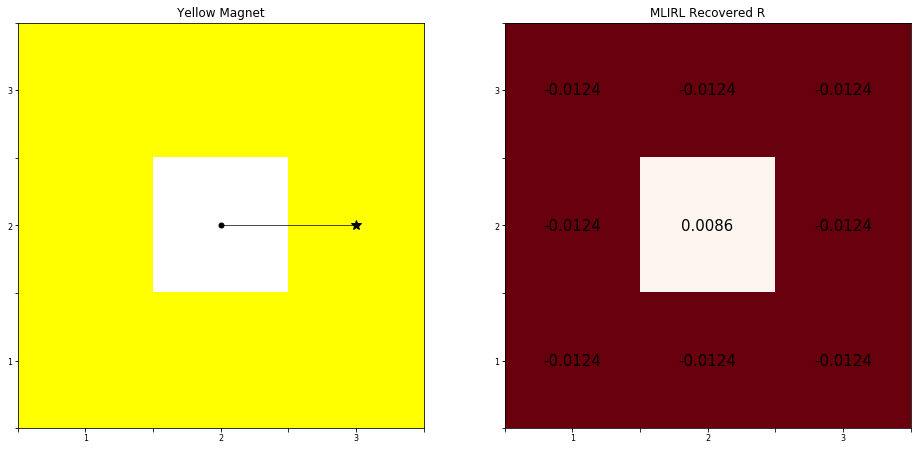

In [5]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=plt.cm.Reds_r)

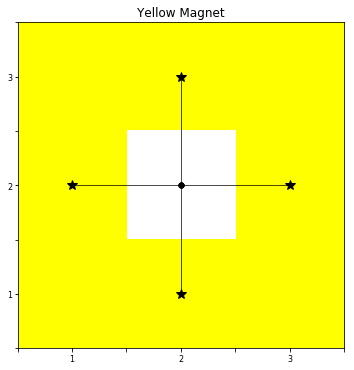

Training...
Iter: 0000, loss: 00005.545178, w: [+0.077749 +0.188758], dw: [+0.0000005 +0.0000096]
Iter: 0001, loss: 00005.545178, w: [+0.076971 +0.186870], dw: [-0.0000002 +0.0000051]
Iter: 0002, loss: 00005.545177, w: [+0.075502 +0.183302], dw: [+0.0000004 +0.0000085]
Iter: 0003, loss: 00005.545178, w: [+0.073424 +0.178258], dw: [-0.0000004 +0.0000034]
Iter: 0004, loss: 00005.545178, w: [+0.070820 +0.171936], dw: [-0.0000005 +0.0000023]
Iter: 0005, loss: 00005.545177, w: [+0.067769 +0.164527], dw: [+0.0000005 +0.0000081]
Iter: 0006, loss: 00005.545178, w: [+0.064344 +0.156213], dw: [-0.0000005 +0.0000015]
Iter: 0007, loss: 00005.545177, w: [+0.060619 +0.147168], dw: [+0.0000000 +0.0000041]
Iter: 0008, loss: 00005.545177, w: [+0.056660 +0.137557], dw: [+0.0000007 +0.0000077]
Iter: 0009, loss: 00005.545178, w: [+0.052530 +0.127530], dw: [-0.0000008 -0.0000018]
Iter: 0010, loss: 00005.545177, w: [+0.048288 +0.117231], dw: [-0.0000008 -0.0000022]
Iter: 0011, loss: 00005.545177, w: [+0.043

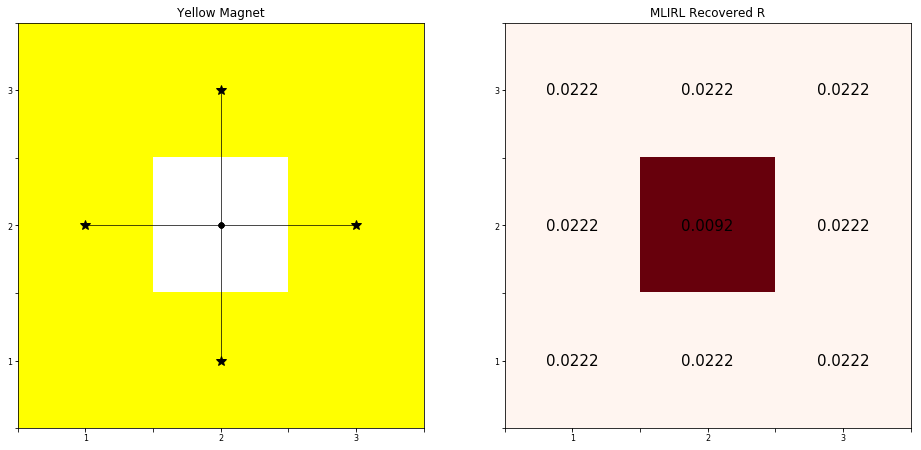

In [6]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [[(2,2)], np.inf],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,1)], [(2,2),(2,3)], [(2,2),(1,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Yellow Magnet",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=plt.cm.Reds_r)

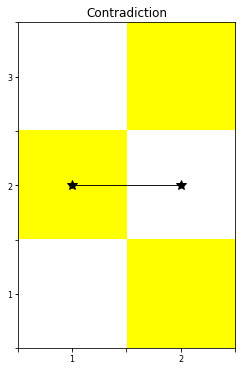

Training...
Iter: 0000, loss: 00002.772726, w: [-0.007314 +0.015703], dw: [-0.0131010 +0.0117464]
Iter: 0001, loss: 00002.772720, w: [-0.007110 +0.015428], dw: [-0.0128438 +0.0114874]
Iter: 0002, loss: 00002.772710, w: [-0.006727 +0.014912], dw: [-0.0123562 +0.0110027]
Iter: 0003, loss: 00002.772695, w: [-0.006191 +0.014188], dw: [-0.0116760 +0.0103227]
Iter: 0004, loss: 00002.772679, w: [-0.005530 +0.013292], dw: [-0.0108350 +0.0094813]
Iter: 0005, loss: 00002.772662, w: [-0.004772 +0.012257], dw: [-0.0098664 +0.0085139]
Iter: 0006, loss: 00002.772645, w: [-0.003943 +0.011118], dw: [-0.0088050 +0.0074506]
Iter: 0007, loss: 00002.772629, w: [-0.003069 +0.009908], dw: [-0.0076792 +0.0063248]
Iter: 0008, loss: 00002.772616, w: [-0.002176 +0.008656], dw: [-0.0065233 +0.0051643]
Iter: 0009, loss: 00002.772605, w: [-0.001284 +0.007391], dw: [-0.0053582 +0.0040015]
Iter: 0010, loss: 00002.772596, w: [-0.000416 +0.006139], dw: [-0.0042141 +0.0028544]
Iter: 0011, loss: 00002.772591, w: [+0.000

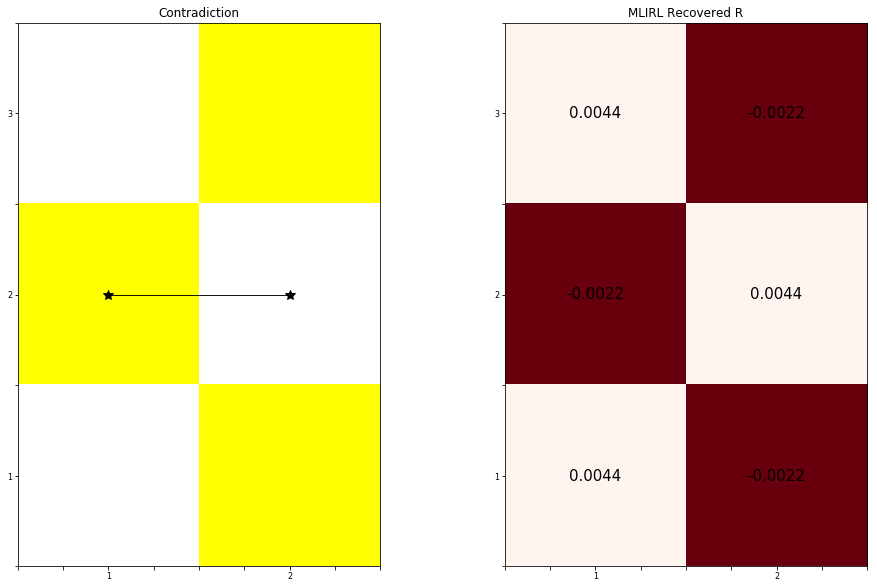

In [7]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 2,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,2),(2,3),(2,1)]],
    tau_s = [[(2,2),(1,2)], [(1,2),(2,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=plt.cm.Reds_r)

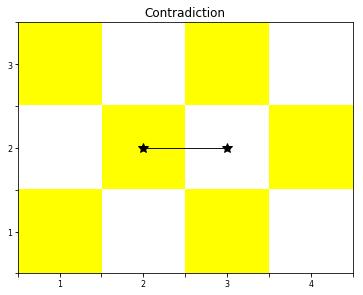

Training...
Iter: 0000, loss: 00002.775453, w: [+0.058761 -0.049644], dw: [+0.0522096 -0.0541731]
Iter: 0001, loss: 00002.775340, w: [+0.057651 -0.048606], dw: [+0.0511418 -0.0531058]
Iter: 0002, loss: 00002.775134, w: [+0.055565 -0.046655], dw: [+0.0491394 -0.0511000]
Iter: 0003, loss: 00002.774858, w: [+0.052640 -0.043921], dw: [+0.0463364 -0.0482943]
Iter: 0004, loss: 00002.774539, w: [+0.049017 -0.040538], dw: [+0.0428725 -0.0448291]
Iter: 0005, loss: 00002.774201, w: [+0.044838 -0.036640], dw: [+0.0388901 -0.0408401]
Iter: 0006, loss: 00002.773867, w: [+0.040240 -0.032357], dw: [+0.0345144 -0.0364694]
Iter: 0007, loss: 00002.773555, w: [+0.035354 -0.027814], dw: [+0.0298848 -0.0318349]
Iter: 0008, loss: 00002.773278, w: [+0.030304 -0.023129], dw: [+0.0251107 -0.0270621]
Iter: 0009, loss: 00002.773046, w: [+0.025205 -0.018410], dw: [+0.0203045 -0.0222575]
Iter: 0010, loss: 00002.772863, w: [+0.020161 -0.013757], dw: [+0.0155647 -0.0175203]
Iter: 0011, loss: 00002.772729, w: [+0.015

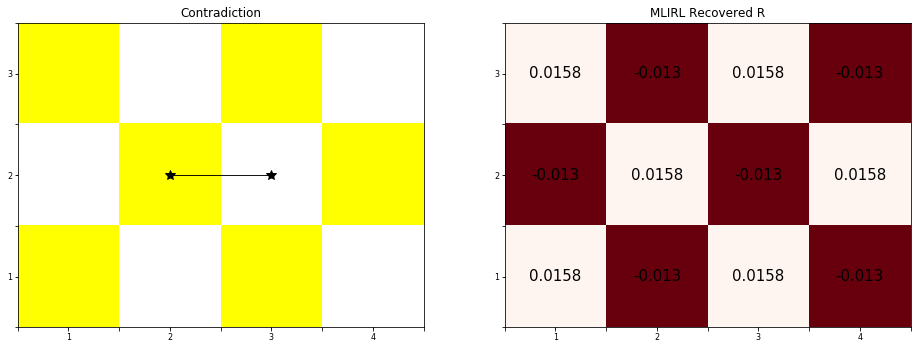

In [8]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 4,
    height = 3,
    cell_types = ['white', 'yellow'],
    cell_locs = [np.inf, [(1,3),(1,1),(2,2),(3,3),(3,1),(4,2)]],
    tau_s = [[(3,2),(2,2)], [(2,2),(3,2)]]
)
irl_problem = dict(
    mdp_params, 
    title="Contradiction",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=plt.cm.Reds_r)

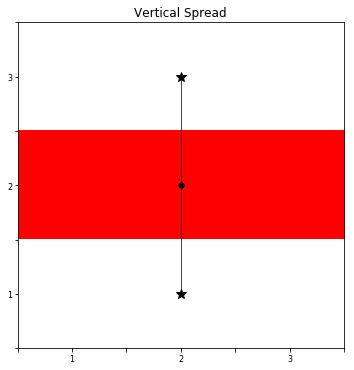

Training...
Iter: 0000, loss: 00002.804519, w: [+0.147008 +0.172973], dw: [-1.2759396 +1.2713356]
Iter: 0001, loss: 00002.772086, w: [+0.158297 +0.158529], dw: [-1.2499951 +1.2452996]
Iter: 0002, loss: 00002.713242, w: [+0.179375 +0.131492], dw: [-1.2013943 +1.1965079]
Iter: 0003, loss: 00002.635417, w: [+0.208565 +0.093879], dw: [-1.1344128 +1.1292315]
Iter: 0004, loss: 00002.546358, w: [+0.244094 +0.047796], dw: [-1.0546193 +1.0490723]
Iter: 0005, loss: 00002.453111, w: [+0.284176 -0.004648], dw: [-0.9683752 +0.9624343]
Iter: 0006, loss: 00002.361296, w: [+0.327091 -0.061425], dw: [-0.8817238 +0.8754014]
Iter: 0007, loss: 00002.274827, w: [+0.371261 -0.120664], dw: [-0.7993492 +0.7927248]
Iter: 0008, loss: 00002.196019, w: [+0.415295 -0.180699], dw: [-0.7242180 +0.7173936]
Iter: 0009, loss: 00002.125926, w: [+0.458015 -0.240099], dw: [-0.6577376 +0.6508099]
Iter: 0010, loss: 00002.064728, w: [+0.498461 -0.297665], dw: [-0.6001422 +0.5932333]
Iter: 0011, loss: 00002.012080, w: [+0.535

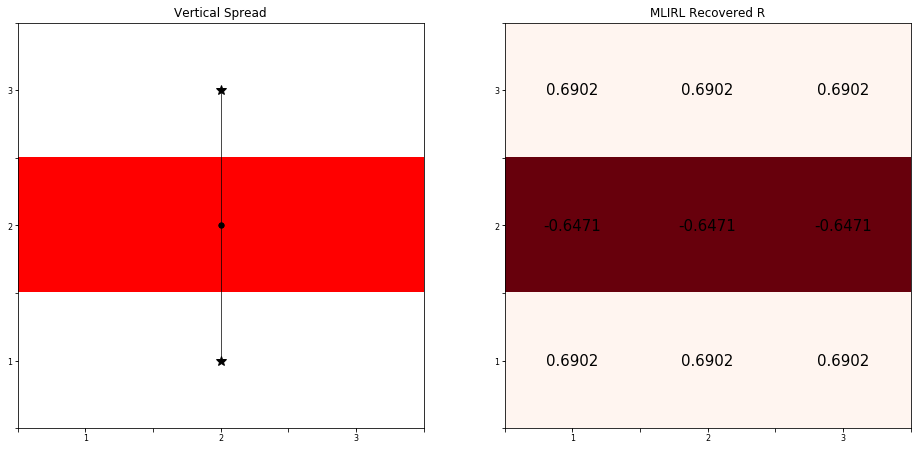

In [9]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white', 'red'],
    cell_locs = [np.inf, [(i,2) for i in range(1,4)]],
    tau_s = [[(2,2),(2,3)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Vertical Spread",
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=plt.cm.Reds_r)

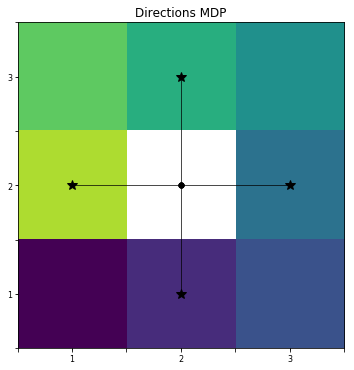

Training...
Iter: 0000, loss: 00005.567404, w: [+0.023746 -0.022803 +0.113380 +0.013095 -0.010222 +0.219895 +0.019140 -0.132131 +0.033479], dw: [-0.0576930 -0.1234641 -0.0606843 +0.0176504 +0.1522105 +0.2974285 +0.1033906 -0.0566957 -0.2724042]
Iter: 0001, loss: 00005.564704, w: [+0.024085 -0.021340 +0.112853 +0.012787 -0.011642 +0.214722 +0.017915 -0.130242 +0.035868], dw: [-0.0513823 -0.1153321 -0.0462014 +0.0221751 +0.1422769 +0.2671838 +0.0931760 -0.0538744 -0.2582183]
Iter: 0002, loss: 00005.560350, w: [+0.024664 -0.018657 +0.111712 +0.012161 -0.014226 +0.205247 +0.015701 -0.126702 +0.040242], dw: [-0.0407371 -0.0996045 -0.0205696 +0.0293963 +0.1234475 +0.2142058 +0.0743975 -0.0488951 -0.2317394]
Iter: 0003, loss: 00005.555649, w: [+0.025345 -0.015060 +0.109774 +0.011182 -0.017644 +0.192525 +0.012808 -0.121759 +0.046093], dw: [-0.0283650 -0.0771092 +0.0114554 +0.0367349 +0.0971820 +0.1486795 +0.0494092 -0.0426018 -0.1953752]
Iter: 0004, loss: 00005.551690, w: [+0.025989 -0.010900 

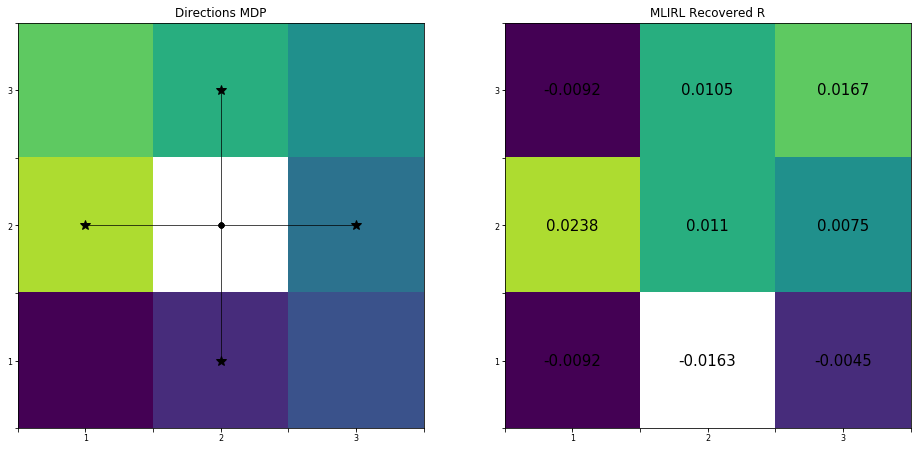

In [10]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 3,
    height = 3,
    cell_types = ['white'] + list(range(0,8)),
    cell_locs = [[(2,2)], [(1,1)], [(2,1)], [(3,1)], [(3,2)], [(3,3)], [(2,3)], [(1,3)], [(1,2)]],
    tau_s = [[(2,2),(3,2)], [(2,2),(2,3)], [(2,2),(1,2)], [(2,2),(2,1)]]
)
irl_problem = dict(
    mdp_params, 
    title="Directions MDP", # not that I like dancing
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=None)

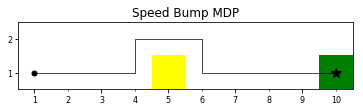

Training...
Iter: 0000, loss: 00015.433543, w: [+0.003146 +0.071392 -0.034262], dw: [+2.1752653 +0.8840741 -3.1193025]
Iter: 0001, loss: 00015.263322, w: [-0.018638 +0.061837 -0.002726], dw: [+2.7141106 +1.0029031 -3.7812698]
Iter: 0002, loss: 00014.761680, w: [-0.065198 +0.042590 +0.063496], dw: [+4.4907923 +1.3203651 -5.8859625]
Iter: 0003, loss: 00013.275932, w: [-0.151358 +0.011639 +0.181320], dw: [+7.1474495 +1.5449603 -8.7444687]
Iter: 0004, loss: 00010.769109, w: [-0.298864 -0.031783 +0.372994], dw: [+5.1463366 +1.3182263 -6.4884596]
Iter: 0005, loss: 00008.892651, w: [-0.480093 -0.083728 +0.606654], dw: [+2.3682277 +1.1600906 -3.5482891]
Iter: 0006, loss: 00007.964391, w: [-0.662081 -0.141242 +0.846366], dw: [+0.5942500 +1.0755827 -1.6922092]
Iter: 0007, loss: 00007.632622, w: [-0.825192 -0.202347 +1.070564], dw: [-0.3490267 +0.9922617 -0.6686767]
Iter: 0008, loss: 00007.583922, w: [-0.960249 -0.265242 +1.268324], dw: [-0.8573545 +0.9270292 -0.0968419]
Iter: 0009, loss: 00007.6

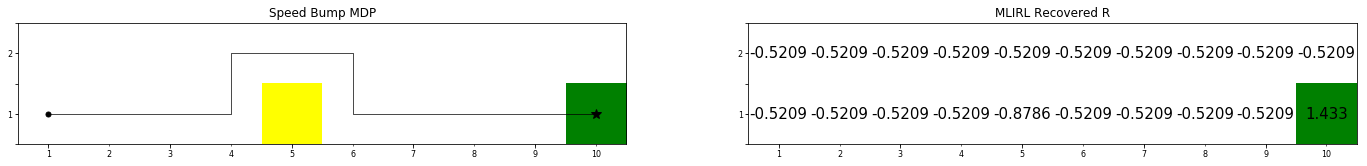

In [11]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 10,
    height = 2,
    cell_types = ['white', "yellow", "green"],
    cell_locs = [np.inf, [(5,1)], [(10,1)]],
    tau_s = [[(i,1) for i in range(1,5)] + [(4,2), (5,2), (6,2)] + [(i,1) for i in range(6,11)]]
)
irl_problem = dict(
    mdp_params, 
    title="Speed Bump MDP", # not that I like dancing
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=None, figsize=(24,12))

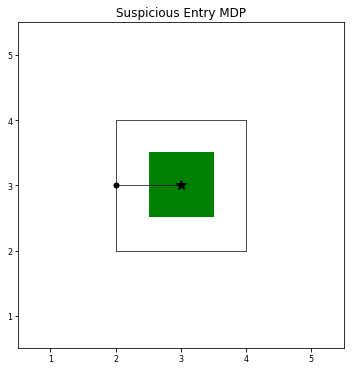

Training...
Iter: 0000, loss: 00012.481842, w: [+0.052090 +0.039246], dw: [+0.4629347 -0.4821632]
Iter: 0001, loss: 00012.477312, w: [+0.046939 +0.043676], dw: [+0.4646475 -0.4838971]
Iter: 0002, loss: 00012.468693, w: [+0.037188 +0.052064], dw: [+0.4679527 -0.4872455]
Iter: 0003, loss: 00012.456361, w: [+0.023361 +0.063965], dw: [+0.4727959 -0.4921224]
Iter: 0004, loss: 00012.440652, w: [+0.005955 +0.078958], dw: [+0.4790464 -0.4984274]
Iter: 0005, loss: 00012.421864, w: [-0.014561 +0.096647], dw: [+0.4865636 -0.5059818]
Iter: 0006, loss: 00012.400273, w: [-0.037745 +0.116659], dw: [+0.4950287 -0.5144560]
Iter: 0007, loss: 00012.376156, w: [-0.063183 +0.138649], dw: [+0.5038582 -0.5232778]
Iter: 0008, loss: 00012.349813, w: [-0.090485 +0.162286], dw: [+0.5121660 -0.5315161]
Iter: 0009, loss: 00012.321615, w: [-0.119273 +0.187251], dw: [+0.5185483 -0.5377680]
Iter: 0010, loss: 00012.292051, w: [-0.149175 +0.213225], dw: [+0.5210241 -0.5400729]
Iter: 0011, loss: 00012.261781, w: [-0.179

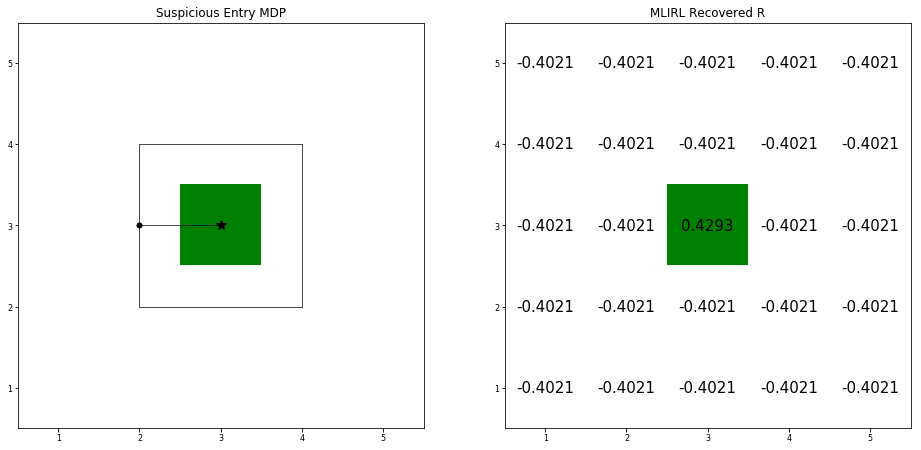

In [12]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"],
    cell_locs = [np.inf, [(3,3)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry MDP", # not that I like dancing
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=None)

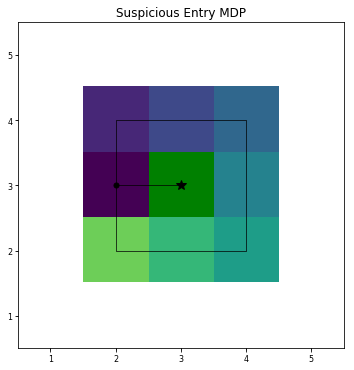

Training...
Iter: 0000, loss: 00012.368921, w: [-0.037744 -0.195856 -0.069006 +0.056565 -0.133273 +0.066694 +0.070075 -0.018305 -0.035863 +0.123095], dw: [+5.5369720 -0.4505890 -0.4796222 -0.2396234 -0.7585663 -0.8695361 -1.0263388 -0.8319805 -0.7516396 -0.1491330]
Iter: 0001, loss: 00012.032237, w: [-0.092736 -0.189392 -0.063520 +0.058396 -0.124354 +0.074723 +0.079638 -0.009802 -0.027988 +0.123356], dw: [+5.1836586 -0.4238498 -0.4190372 -0.2049769 -0.7226011 -0.8258156 -1.0016546 -0.7927074 -0.7056642 -0.1062899]
Iter: 0002, loss: 00011.481326, w: [-0.193139 -0.177441 -0.053757 +0.061509 -0.107858 +0.089459 +0.097464 +0.005875 -0.013564 +0.123419], dw: [+4.3808851 -0.3326133 -0.3078398 -0.1494191 -0.6369283 -0.7237861 -0.9072880 -0.6998258 -0.5994447 -0.0404716]
Iter: 0003, loss: 00010.898197, w: [-0.325378 -0.161585 -0.041354 +0.065190 -0.085564 +0.109065 +0.121606 +0.026925 +0.005548 +0.122647], dw: [+3.3104563 -0.1623559 -0.1909565 -0.1022824 -0.5163315 -0.5909511 -0.7370963 -0.576

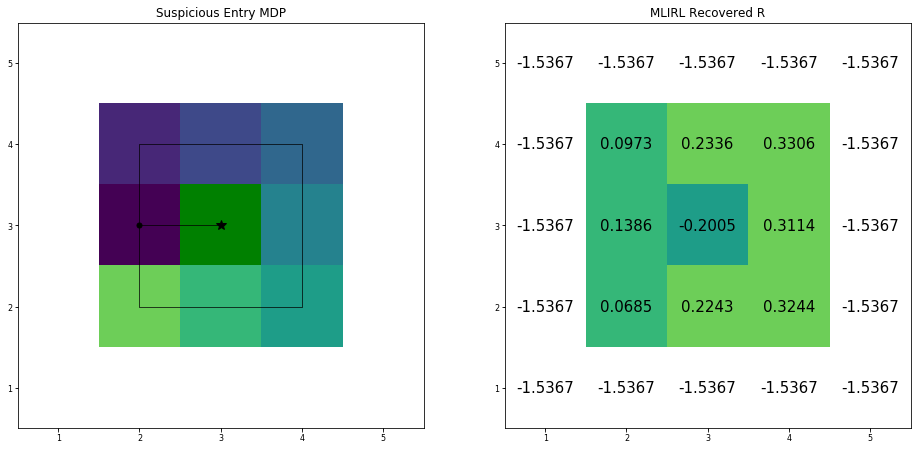

In [13]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 50,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Suspicious Entry MDP", # not that I like dancing
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=None)

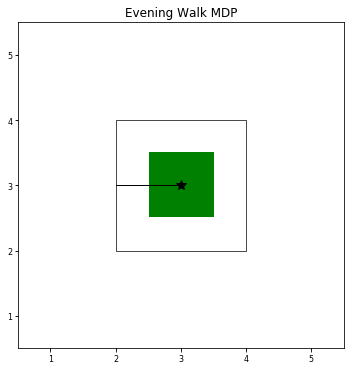

Training...
Iter: 0000, loss: 00013.800826, w: [-0.004710 +0.120294], dw: [+0.3910413 -0.5146147]
Iter: 0001, loss: 00013.797281, w: [-0.008573 +0.124237], dw: [+0.3925161 -0.5163016]
Iter: 0002, loss: 00013.790529, w: [-0.015890 +0.131707], dw: [+0.3952959 -0.5194900]
Iter: 0003, loss: 00013.780875, w: [-0.026268 +0.142307], dw: [+0.3992361 -0.5239771]
Iter: 0004, loss: 00013.768589, w: [-0.039339 +0.155664], dw: [+0.4041208 -0.5295042]
Iter: 0005, loss: 00013.753925, w: [-0.054750 +0.171424], dw: [+0.4096403 -0.5357178]
Iter: 0006, loss: 00013.737128, w: [-0.072170 +0.189251], dw: [+0.4153723 -0.5421100]
Iter: 0007, loss: 00013.718470, w: [-0.091279 +0.208823], dw: [+0.4206183 -0.5479725]
Iter: 0008, loss: 00013.698247, w: [-0.111771 +0.229830], dw: [+0.4245194 -0.5523270]
Iter: 0009, loss: 00013.676823, w: [-0.133341 +0.251961], dw: [+0.4258475 -0.5539209]
Iter: 0010, loss: 00013.654644, w: [-0.155679 +0.274899], dw: [+0.4231786 -0.5512270]
Iter: 0011, loss: 00013.632271, w: [-0.178

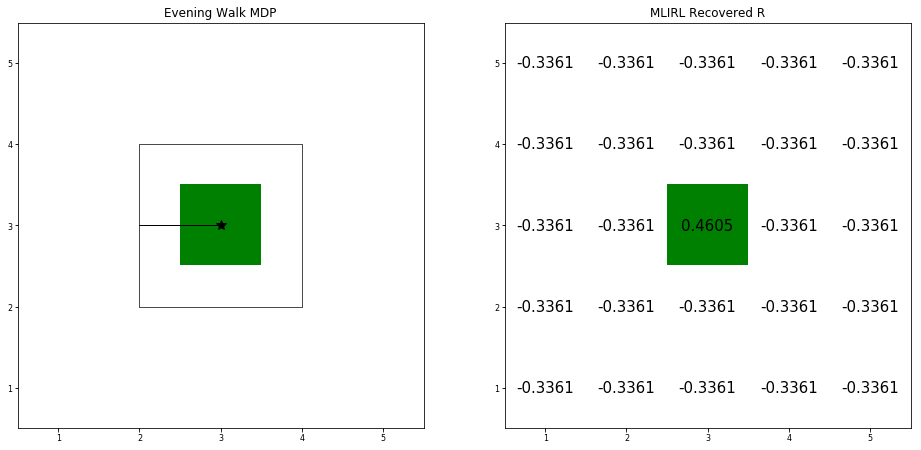

In [14]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 30,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"],
    cell_locs = [np.inf, [(3,3)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Evening Walk MDP", # not that I like dancing
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=None)

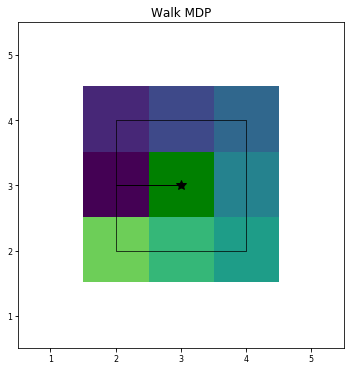

Training...
Iter: 0000, loss: 00014.329747, w: [+0.101465 -0.106453 +0.048616 +0.017041 +0.010393 -0.103076 +0.121022 +0.238279 -0.060797 -0.033097], dw: [+5.8941669 -0.4834511 -1.5152483 -0.5913434 -0.5661439 -0.6203314 -0.5473387 -0.5309229 -0.5560380 -0.6022698]
Iter: 0001, loss: 00013.936828, w: [+0.041509 -0.100554 +0.063282 +0.022784 +0.015950 -0.095842 +0.125286 +0.241205 -0.054628 -0.026744], dw: [+5.6461248 -0.4803143 -1.4810854 -0.5566394 -0.5427265 -0.5944496 -0.5196302 -0.4892195 -0.5307566 -0.5692636]
Iter: 0002, loss: 00013.267357, w: [-0.069328 -0.089436 +0.090660 +0.033291 +0.026220 -0.082429 +0.133066 +0.246319 -0.043223 -0.015065], dw: [+4.9292183 -0.4258428 -1.3819849 -0.4781945 -0.4743925 -0.5323418 -0.4240974 -0.3814911 -0.4505964 -0.4932006]
Iter: 0003, loss: 00012.534467, w: [-0.217680 -0.074278 +0.128213 +0.047197 +0.039944 -0.064209 +0.142978 +0.252273 -0.028020 +0.000528], dw: [+3.7058964 -0.2508602 -1.2040467 -0.3741221 -0.3528319 -0.4440088 -0.2478780 -0.239

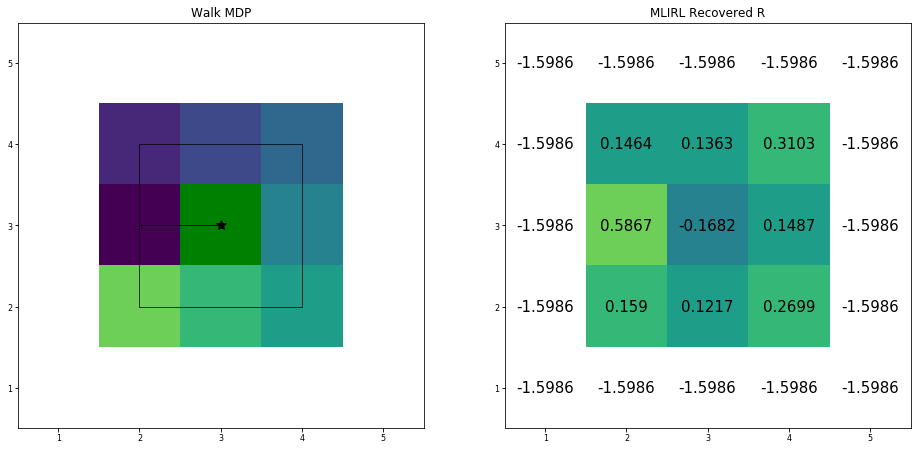

In [15]:
mlirl_params = dict(
    n_iter = 20,
    n_vi_iter = 30,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    optimizer_fn = lambda params: optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1.)
)
mdp_params = dict(
    width = 5,
    height = 5,
    cell_types = ['white', "green"] + list(range(8)),
    cell_locs = [np.inf, [(3,3)], [(2,3)], [(2,4)], [(3,4)], [(4,4)], [(4,3)], [(4,2)], [(3,2)], [(2,2)]],
    tau_s = [[(3,3),(2,3),(2,4),(3,4),(4,4),(4,3),(4,2),(3,2),(2,2),(2,3),(3,3)]]
)
irl_problem = dict(
    mdp_params, 
    title="Walk MDP", # not that I like dancing
    traj_states = [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in mdp_params["tau_s"]],
    traj_actions = [get_actions_from_state_traj(state_traj) for state_traj in mdp_params["tau_s"]]
)

results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["traj_states"], results["R"].round(4), irl_problem["title"], cmap=None)